#### import packages

In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import rdkit
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from joblib import Parallel, delayed

# print rdkit version
print(rdkit.__version__)

# Configure pandas display options
pd.set_option('display.max_rows', 20)

# Set font style for plot
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.figsize'] = [10.5, 7.5]

# Install RDKit pandas tools
PandasTools.InstallPandasTools()

# Suppress RDKit warnings and running information
from rdkit import rdBase
rdBase.DisableLog('rdApp.warning')
rdBase.DisableLog('rdApp.info')

# Ignore copy warning
pd.options.mode.chained_assignment = None  # default='warn'

# Add project root to path for importing project modules
import sys
sys.path.append('../')
from src.utils.mol_utils import get_inchi_noStereo_from_smi, get_inchi_noStereo_from_mol

2023.09.5


# build groups data sets

In [2]:
az_public_df = pd.read_csv('../data/az_shared_MetID/120_compounds_with_SoM_annotations.csv')
len(az_public_df)

120

In [3]:
az_public_df = az_public_df[az_public_df.Comment.isin(['mol has at least one exact SoM','mol is metabolically stable in the specific experimental setting'])]
len(az_public_df)

99

In [4]:
az_public_df = az_public_df.rename(columns={
    'Compound ID': 'mol_id',
    'SMILES': 'preprocessed_smi',
    'SoMs grouped (numbers provided are atom indices)': 'soms',
    'Exact SoM annotation (1) or extended SoM annotation (0) per group': 'certain'
})
az_public_df.columns

Index(['mol_id', 'preprocessed_smi', 'soms', 'certain', 'Comment'], dtype='object')

In [5]:
az_public_df['inchi_noStereo'] = az_public_df['preprocessed_smi'].map(get_inchi_noStereo_from_smi)
az_public_df.drop_duplicates(subset=['inchi_noStereo'],inplace=True)
len(az_public_df)

98

In [6]:
for col in ['soms', 'certain']:
    az_public_df[col] = az_public_df[col].map(ast.literal_eval)

In [7]:
groups_az_public_df = az_public_df.explode(['soms', 'certain']).reset_index(drop=True)
groups_az_public_df.head(10)

,mol_id,preprocessed_smi,soms,certain,Comment,inchi_noStereo
0,Cmpd 2,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,34,1,mol has at least one exact SoM,InChI=1S/C29H38FN3O3/c1-20(2)28-23-12-11-22(30...
1,Cmpd 2,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,30,1,mol has at least one exact SoM,InChI=1S/C29H38FN3O3/c1-20(2)28-23-12-11-22(30...
2,Cmpd 2,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"18,19,20,21,22,23,24,25,26,27,28",0,mol has at least one exact SoM,InChI=1S/C29H38FN3O3/c1-20(2)28-23-12-11-22(30...
3,Cmpd 3,C[C@H](CO)Nc1cc(NS(C)(=O)=O)nc(SCc2cccc(F)c2F)n1,1,1,mol has at least one exact SoM,InChI=1S/C15H18F2N4O3S2/c1-9(7-22)18-12-6-13(2...
4,Cmpd 3,C[C@H](CO)Nc1cc(NS(C)(=O)=O)nc(SCc2cccc(F)c2F)n1,"2,3",1,mol has at least one exact SoM,InChI=1S/C15H18F2N4O3S2/c1-9(7-22)18-12-6-13(2...
5,Cmpd 3,C[C@H](CO)Nc1cc(NS(C)(=O)=O)nc(SCc2cccc(F)c2F)n1,"3,4,25,13",0,mol has at least one exact SoM,InChI=1S/C15H18F2N4O3S2/c1-9(7-22)18-12-6-13(2...
6,Cmpd 3,C[C@H](CO)Nc1cc(NS(C)(=O)=O)nc(SCc2cccc(F)c2F)n1,"3,4,25,13",0,mol has at least one exact SoM,InChI=1S/C15H18F2N4O3S2/c1-9(7-22)18-12-6-13(2...
7,Cmpd 3,C[C@H](CO)Nc1cc(NS(C)(=O)=O)nc(SCc2cccc(F)c2F)n1,"18,19,20",0,mol has at least one exact SoM,InChI=1S/C15H18F2N4O3S2/c1-9(7-22)18-12-6-13(2...
8,Cmpd 4,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...,42,1,mol has at least one exact SoM,InChI=1S/C47H51NO14/c1-25-31(60-43(56)36(52)35...
9,Cmpd 4,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...,18,1,mol has at least one exact SoM,InChI=1S/C47H51NO14/c1-25-31(60-43(56)36(52)35...


In [8]:
# Calculate statistics about SOM annotations groups:
# - Total number of SOM annotations after exploding the dataframe
# - Average number of SOM annotations per molecule (total/original length)
print(f"Total SOM annotation groups: {len(groups_az_public_df)}")
print(f"Average SOM groups per molecule: {len(groups_az_public_df)/len(az_public_df):.2f}")

Total SOM annotation groups: 339
Average SOM groups per molecule: 3.46


In [9]:
parent_remain_ids = list(set(groups_az_public_df[groups_az_public_df['soms']=='none'].mol_id))
print('number of parent remaining compounds:')
len(set(groups_az_public_df[groups_az_public_df['soms']=='none'].mol_id)) # no duplicates

number of parent remaining compounds:


4

In [10]:
groups_az_public_df[groups_az_public_df.mol_id.isin(parent_remain_ids)]

,mol_id,preprocessed_smi,soms,certain,Comment,inchi_noStereo
104,Cmpd 36,O=C(N[C@H]1CN(S(=O)(=O)c2ccccc2)C[C@@H]1C(=O)N...,none,1,mol is metabolically stable in the specific ex...,InChI=1S/C26H29N5O5S/c32-25(28-19-10-7-13-27-1...
275,Cmpd 89,CC1(C)Oc2cc(NS(C)(=O)=O)ccc2N(c2ccc(F)cc2)C1=O,none,1,mol is metabolically stable in the specific ex...,InChI=1S/C17H17FN2O4S/c1-17(2)16(21)20(13-7-4-...
280,Cmpd 93,NC(=O)CC1COc2cc(F)ccc2N1C(=O)c1ccc2c(c1)NC(=O)CO2,none,1,mol is metabolically stable in the specific ex...,InChI=1S/C19H16FN3O5/c20-11-2-3-14-16(6-11)27-...
305,Cmpd 106,CNC(=O)CC1COc2ccccc2N1C(=O)c1ccc2c(c1)NC(=O)CO2,none,1,mol is metabolically stable in the specific ex...,InChI=1S/C20H19N3O5/c1-21-18(24)9-13-10-27-17-...


In [11]:
len(set(groups_az_public_df.drop_duplicates(['mol_id','soms','certain']).mol_id))
# no molecule would be removed

98

In [12]:
# -14 no SoMs
print('groups also count for the 14 parent remaining compounds, here remove them:')
len(groups_az_public_df)-14, len(set(groups_az_public_df.mol_id)), (len(groups_az_public_df)-14)/len(set(groups_az_public_df.mol_id))

groups also count for the 14 parent remaining compounds, here remove them:


(325, 98, 3.316326530612245)

In [13]:
# -14 no SoMs, -14 compounds
len(groups_az_public_df)-14, len(set(groups_az_public_df.mol_id))-14, (len(groups_az_public_df)-14)/(len(set(groups_az_public_df.mol_id))-14)

(325, 84, 3.869047619047619)

In [14]:
groups_az_public_df[groups_az_public_df.soms!='none'].to_csv('../data/az_shared_MetID/az_sharedMetID_annotation_groups_nodup.csv',index=False)

In [15]:
# explicit annotations
groups_az_df_dropdup_explicit = groups_az_public_df[groups_az_public_df.certain=='1']
print('number of SoM groups for the explicit annotation:')
len(groups_az_df_dropdup_explicit) -14

number of SoM groups for the explicit annotation:


202

# SoM statistics

## number of SoMs groups

In [16]:
# the values of compounds rows is the number of SoMs gorups, but there are 14 parent remaining, so 0 SoM
from collections import Counter

group_counts = Counter(list(groups_az_public_df.value_counts('mol_id')))
group_counts[1] = group_counts[1] - 14
group_counts[0] = 14
group_counts

Counter({3: 21, 2: 21, 4: 17, 5: 14, 0: 14, 6: 9, 8: 2, 7: 2, 1: -2})

In [17]:
# if only consider explicit annotation
group_counts_certain = Counter(list(groups_az_df_dropdup_explicit.value_counts('mol_id')))
group_counts_certain[1] = group_counts_certain[1] - 14
group_counts_certain[0] = 14
group_counts_certain

Counter({2: 31, 1: 24, 0: 14, 4: 13, 3: 9, 5: 5, 6: 2})

## proportion of SoMs/atoms

In [18]:
len(groups_az_public_df[groups_az_public_df['soms'].apply(lambda x: 'none' in x)])

4

In [19]:
from rdkit import Chem
from rdkit.Chem import Lipinski

def get_num_heavy_atoms(smi):
    return Lipinski.HeavyAtomCount(Chem.MolFromSmiles(smi))

In [20]:
from collections import defaultdict

def find_symmetry_classes(mol_input, input_type='smiles'):
    """Find sets of topologically equivalent atoms in a molecule.
    
    Args:
        mol_input: Either a SMILES string or RDKit Mol object
        input_type: String specifying input type ('smiles' or 'mol')
    
    Returns:
        set: Sets of symmetry-equivalent atom indices as tuples
        
    Note: This is not the most efficient approach for large numbers of molecules,
    particularly those with high symmetry, but it works reliably.
    """
    if input_type == 'smiles':
        mol = Chem.MolFromSmiles(mol_input)
    elif input_type == 'mol':
        mol = mol_input
    else:
        raise ValueError("input_type must be 'smiles' or 'mol'")
        
    # Find all atom-atom mappings
    equivs = defaultdict(set)
    matches = mol.GetSubstructMatches(mol, uniquify=False)
    
    # Group equivalent atoms
    for match in matches:
        for idx1, idx2 in enumerate(match):
            equivs[idx1].add(idx2)
            
    # Convert to set of tuples
    symmetry_classes = {tuple(s) for s in equivs.values()}
    
    return symmetry_classes

In [21]:
def label_som_equvalence(symmetry_class_set, soms_list):
    """
    Maps SoM indices to their symmetry equivalence classes.
    
    Args:
        symmetry_class_set: Set of tuples containing symmetrically equivalent atom indices
        soms_list: List of SoM indices as strings
        
    Returns:
        List of symmetry equivalence classes (tuples) for each SoM
    """
    if 'none' in soms_list:
        return []
    
    # Create mapping from atom index to its symmetry class
    groups = {}
    for symmetry_class in symmetry_class_set:
        for atom_idx in symmetry_class:
            groups[atom_idx] = symmetry_class
            
    # Map each SoM to its symmetry class if it exists
    groups_label = []
    for som in soms_list:
        som_idx = int(som)
        if som_idx in groups:
            groups_label.append(groups[som_idx])
            
    return groups_label

def count_unique_soms(symmetry_class_set, soms_list):
    """Count number of unique symmetry classes that contain SoM atoms.
    
    Args:
        symmetry_class_set: Set of tuples containing symmetry-equivalent atom indices
        soms_list: List of SoM atom indices as strings
        
    Returns:
        int: Number of unique symmetry classes containing SoM atoms
    """
    return len(set(label_som_equvalence(symmetry_class_set, soms_list)))

In [22]:
def convert_soms_to_list(soms_list):
    if 'none' in soms_list:
        return ['none']
    return list(set(item for sublist in soms_list for item in str(sublist).split(',') if item))

# convert list of lists to list
az_public_df['som_list'] = az_public_df['soms'].map(convert_soms_to_list)
# convert list of lists to list for the exact annotation
az_public_df['soms_exact'] = az_public_df.apply(lambda row: [som for som, certain in zip(row['soms'], row['certain']) if certain == '1'], axis=1)
az_public_df['som_list_explicit'] = az_public_df['soms_exact'].map(convert_soms_to_list)

#  Count unique SoMs per molecule, set to 0 if 'none' in soms
az_public_df['num_soms'] = az_public_df['som_list'].map(lambda x: len(set(x)))
az_public_df.loc[az_public_df['soms'].map(lambda x: 'none' in x),'num_soms'] = 0

# Calculate number of heavy atoms from SMILES
az_public_df['num_HeavyAtoms'] = az_public_df['preprocessed_smi'].map(get_num_heavy_atoms)

# Calculate proportion of atoms that are SoMs
az_public_df['proportion_soms'] = az_public_df['num_soms'] / az_public_df['num_HeavyAtoms']               

# Find topologically equivalent atoms using symmetry classes
az_public_df['symmetry_classes'] = az_public_df['preprocessed_smi'].map(find_symmetry_classes)

# Count number of unique heavy atoms based on symmetry classes
az_public_df['num_uniq_HeavyAtoms'] = az_public_df['symmetry_classes'].map(lambda x:len(x))

# Count number of unique symmetry classes containing SoMs
az_public_df['num_unique_soms'] = az_public_df.apply(lambda row: count_unique_soms(row['symmetry_classes'], row['som_list']), axis=1)

# Calculate proportion of unique atoms that are SoMs
az_public_df['proportion_unique_soms'] = az_public_df['num_unique_soms'] / az_public_df['num_uniq_HeavyAtoms']

In [23]:
az_public_df['num_soms_explicit'] = az_public_df['som_list_explicit'].map(lambda x: len(set(x)))
az_public_df.loc[az_public_df['soms_exact'].map(lambda x: 'none' in x),'num_soms_explicit'] = 0

az_public_df['proportion_soms_explicit'] = az_public_df['num_soms_explicit'] / az_public_df['num_HeavyAtoms']   

# Count number of unique symmetry classes containing SoMs
az_public_df['num_unique_soms_explicit'] = az_public_df.apply(lambda row: count_unique_soms(row['symmetry_classes'], row['som_list_explicit']), axis=1)

# Calculate proportion of unique atoms that are SoMs
az_public_df['proportion_unique_soms_explicit'] = az_public_df['num_unique_soms_explicit'] / az_public_df['num_uniq_HeavyAtoms']

In [24]:
len(az_public_df)

98

In [25]:
az_public_df.columns

Index(['mol_id', 'preprocessed_smi', 'soms', 'certain', 'Comment',
       'inchi_noStereo', 'som_list', 'soms_exact', 'som_list_explicit',
       'num_soms', 'num_HeavyAtoms', 'proportion_soms', 'symmetry_classes',
       'num_uniq_HeavyAtoms', 'num_unique_soms', 'proportion_unique_soms',
       'num_soms_explicit', 'proportion_soms_explicit',
       'num_unique_soms_explicit', 'proportion_unique_soms_explicit'],
      dtype='object')

In [26]:
# count the number of compounds with more than 50% and 70% of the atoms as SoMs
len(az_public_df[az_public_df.proportion_unique_soms >0.5]), len(az_public_df[az_public_df.proportion_unique_soms >0.7])

(7, 0)

In [27]:
# print the calculated results
print('For extended annotation compounds:')
print(f"Total number of heavy atoms: {az_public_df['num_HeavyAtoms'].sum()}")
print(f"Total number of heavy atoms of compounds with SoMs: {az_public_df[az_public_df.num_soms > 0]['num_HeavyAtoms'].sum()}")
print(f"Total number of heavy atoms of compounds without SoMs: {az_public_df[az_public_df.num_soms == 0]['num_HeavyAtoms'].sum()}")

# calculate and print the number of soms of all compounds and the number of soms of compounds with SoMs
print('\nFor extended annoation compounds:')
print(f"Total number of soms: {az_public_df['num_soms'].sum()}")
print(f"Total number of soms of compounds with SoMs: {az_public_df[az_public_df.num_soms > 0]['num_soms'].sum()}")
print(f"Total number of soms of compounds without SoMs: {az_public_df[az_public_df.num_soms == 0]['num_soms'].sum()}")

# calculate the average number of soms per compound
print(f"\nAverage number of soms per compound: {az_public_df['num_soms'].mean()}")
print(f"Average number of soms per compound with SoMs: {az_public_df[az_public_df.num_soms > 0]['num_soms'].mean()}")
print(f"Average number of soms per compound without SoMs: {az_public_df[az_public_df.num_soms == 0]['num_soms'].mean()}")

# do the same for the explicit annotation
print('\nFor exact annotaion compounds:')
print(f"Total number of soms: {az_public_df['num_soms_explicit'].sum()}")
print(f"Total number of soms of compounds with SoMs: {az_public_df[az_public_df.num_soms_explicit > 0]['num_soms_explicit'].sum()}")
print(f"Total number of soms of compounds without SoMs: {az_public_df[az_public_df.num_soms_explicit == 0]['num_soms_explicit'].sum()}")

# calculate the average number of soms per compound for the explicit annotation
print('\nFor exact annotaion compounds:')
print(f"Average number of soms per compound for the explicit annotation: {az_public_df['num_soms_explicit'].mean()}")
print(f"Average number of soms per compound with SoMs for the explicit annotation: {az_public_df[az_public_df.num_soms_explicit > 0]['num_soms_explicit'].mean()}")
print(f"Average number of soms per compound without SoMs for the explicit annotation: {az_public_df[az_public_df.num_soms_explicit == 0]['num_soms_explicit'].mean()}")


For extended annotation compounds:
Total number of heavy atoms: 2995
Total number of heavy atoms of compounds with SoMs: 2877
Total number of heavy atoms of compounds without SoMs: 118

For extended annoation compounds:
Total number of soms: 650
Total number of soms of compounds with SoMs: 650
Total number of soms of compounds without SoMs: 0

Average number of soms per compound: 6.63265306122449
Average number of soms per compound with SoMs: 6.914893617021277
Average number of soms per compound without SoMs: 0.0

For exact annotaion compounds:
Total number of soms: 226
Total number of soms of compounds with SoMs: 226
Total number of soms of compounds without SoMs: 0

For exact annotaion compounds:
Average number of soms per compound for the explicit annotation: 2.306122448979592
Average number of soms per compound with SoMs for the explicit annotation: 2.404255319148936
Average number of soms per compound without SoMs for the explicit annotation: 0.0


In [28]:
# print the calculated results
print('\nFor extended annotation compounds:')
print(f"Total number of unique heavy atoms: {az_public_df['num_uniq_HeavyAtoms'].sum()}")
print(f"Total number of unique heavy atoms of compounds with SoMs: {az_public_df[az_public_df.num_unique_soms > 0]['num_uniq_HeavyAtoms'].sum()}")
print(f"Total number of unique heavy atoms of compounds without SoMs: {az_public_df[az_public_df.num_unique_soms == 0]['num_uniq_HeavyAtoms'].sum()}")

print('\nFor extended annotation compounds:')
print(f"Total number of unique soms: {az_public_df['num_unique_soms'].sum()}")
print(f"Total number of unique soms of compounds with SoMs: {az_public_df[az_public_df.num_unique_soms > 0]['num_unique_soms'].sum()}")
print(f"Total number of unique soms of compounds without SoMs: {az_public_df[az_public_df.num_unique_soms == 0]['num_unique_soms'].sum()}")

print('\nFor exact annotation compounds:')
print(f"Total number of unique soms: {az_public_df['num_unique_soms_explicit'].sum()}")
print(f"Total number of unique soms of compounds with SoMs: {az_public_df[az_public_df.num_unique_soms_explicit > 0]['num_unique_soms_explicit'].sum()}")
print(f"Total number of unique soms of compounds without SoMs: {az_public_df[az_public_df.num_unique_soms_explicit == 0]['num_unique_soms_explicit'].sum()}")

print('\nAverage number of unique soms per compound:')
print(f"All compounds: {az_public_df['num_unique_soms'].mean():.2f}")
print(f"Compounds with SoMs: {az_public_df[az_public_df.num_unique_soms > 0]['num_unique_soms'].mean():.2f}")
print(f"Compounds without SoMs: {az_public_df[az_public_df.num_unique_soms == 0]['num_unique_soms'].mean():.2f}")

print('\nAverage number of unique soms per compound (alternative calculation):')
print(f"All compounds: {az_public_df['num_unique_soms'].mean():.2f}")
print(f"Compounds with SoMs: {az_public_df[az_public_df.num_soms > 0]['num_unique_soms'].mean():.2f}")
print(f"Compounds without SoMs: {az_public_df[az_public_df.num_soms == 0]['num_unique_soms'].mean():.2f}")


For extended annotation compounds:
Total number of unique heavy atoms: 2709
Total number of unique heavy atoms of compounds with SoMs: 2600
Total number of unique heavy atoms of compounds without SoMs: 109

For extended annotation compounds:
Total number of unique soms: 581
Total number of unique soms of compounds with SoMs: 581
Total number of unique soms of compounds without SoMs: 0

For exact annotation compounds:
Total number of unique soms: 202
Total number of unique soms of compounds with SoMs: 202
Total number of unique soms of compounds without SoMs: 0

Average number of unique soms per compound:
All compounds: 5.93
Compounds with SoMs: 6.18
Compounds without SoMs: 0.00

Average number of unique soms per compound (alternative calculation):
All compounds: 5.93
Compounds with SoMs: 6.18
Compounds without SoMs: 0.00


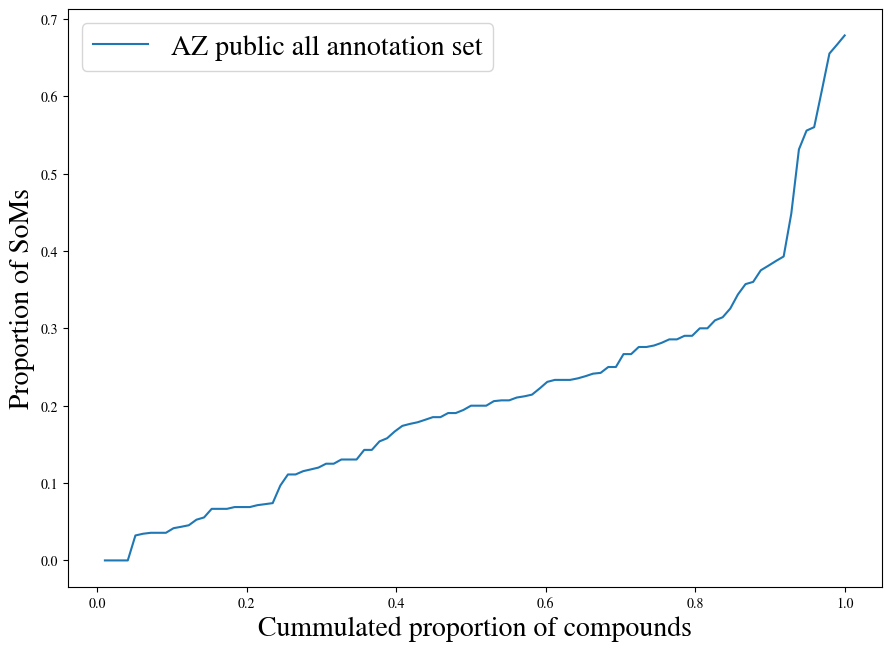

In [29]:
plt.plot(np.arange(1,len(az_public_df)+1)/len(az_public_df), 
        az_public_df.proportion_unique_soms.sort_values().to_numpy(), 
        label='AZ public all annotation set')

plt.legend(fontsize=20)

plt.xlabel('Cummulated proportion of compounds', fontsize=20)
plt.ylabel('Proportion of SoMs', fontsize=20)
plt.show()

In [30]:
# no. SoMs all annotation
print('Extened annotation:')
print('Number of unique SoMs and average number of unique SoMs per molecule:')
sum(az_public_df.num_unique_soms), sum(az_public_df.num_unique_soms)/len(az_public_df)

Extened annotation:
Number of unique SoMs and average number of unique SoMs per molecule:


(581, 5.928571428571429)

In [31]:
# no. SoMs all annotation, remove 14 cpds
sum(az_public_df.num_unique_soms), sum(az_public_df.num_unique_soms)/(len(az_public_df)-14)

(581, 6.916666666666667)

In [32]:
# fraction of SoMs among heavy atoms, all annotation
print('average fraction of SoMs per molecule (no meaning!)')
sum(az_public_df.proportion_unique_soms)/len(az_public_df)

average fraction of SoMs per molecule (no meaning!)


0.21310601422945732

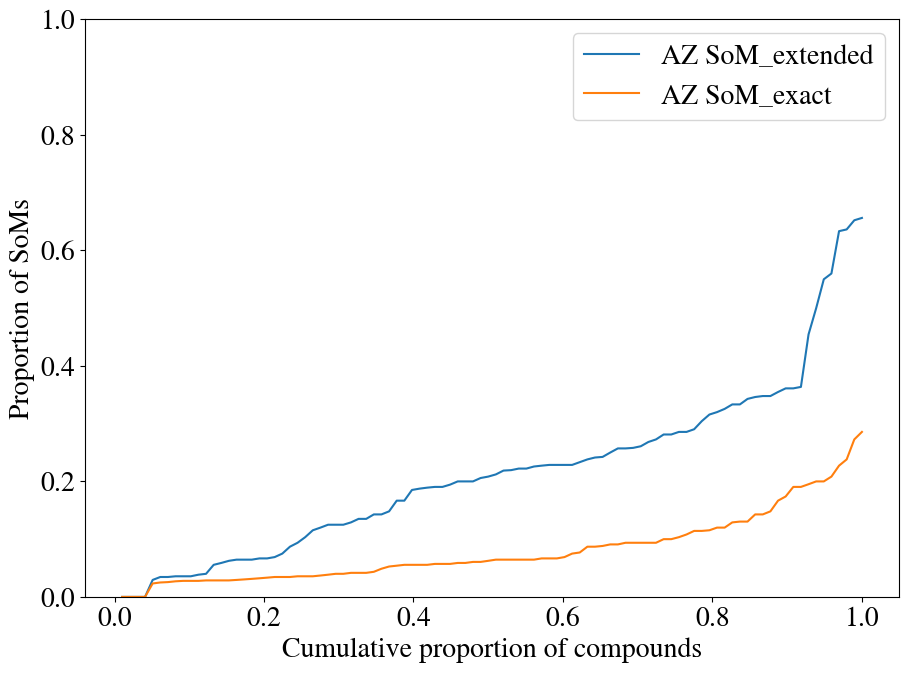

In [33]:
plt.plot(np.arange(1,len(az_public_df)+1)/len(az_public_df), 
        az_public_df.proportion_soms.sort_values().to_numpy(), 
        label='AZ SoM_extended')

plt.plot(np.arange(1,len(az_public_df)+1)/len(az_public_df), 
        az_public_df.proportion_soms_explicit.sort_values().to_numpy(), 
        label='AZ SoM_exact')

plt.legend(fontsize=20)
plt.tick_params(labelsize=20)
plt.ylim(0, 1.0)

plt.xlabel('Cumulative proportion of compounds',fontsize=20)
plt.ylabel('Proportion of SoMs',fontsize=20)
plt.show()

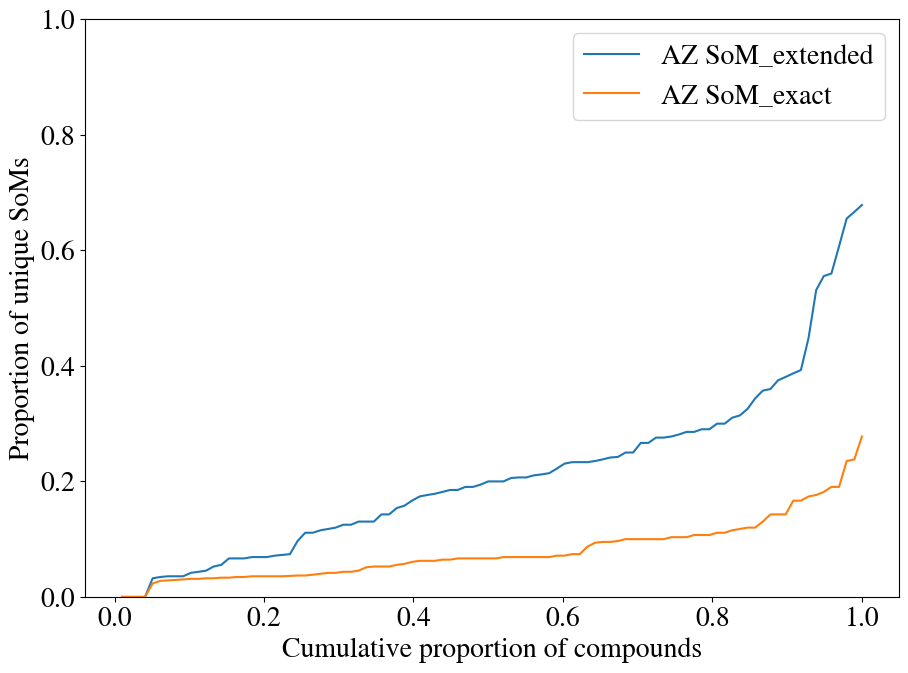

In [34]:
# make a figure for the proportion of unique soms
plt.plot(np.arange(1,len(az_public_df)+1)/len(az_public_df), 
        az_public_df.proportion_unique_soms.sort_values().to_numpy(), 
        label='AZ SoM_extended')

plt.plot(np.arange(1,len(az_public_df)+1)/len(az_public_df), 
        az_public_df.proportion_unique_soms_explicit.sort_values().to_numpy(), 
        label='AZ SoM_exact')

plt.legend(fontsize=20)
plt.tick_params(labelsize=20)
plt.ylim(0, 1.0)

plt.xlabel('Cumulative proportion of compounds',fontsize=20)
plt.ylabel('Proportion of unique SoMs',fontsize=20)
plt.show()

# build atoms sets

In [35]:
az_public_df['symmetry_label'] = az_public_df.apply(lambda row: label_som_equvalence(row.symmetry_classes, row.som_list), axis=1)
az_public_df['symmetry_label_explicit'] = az_public_df.apply(lambda row: label_som_equvalence(row.symmetry_classes, row.som_list_explicit), axis=1)

In [36]:
len(az_public_df.explode(['som_list','symmetry_label'])),len(az_public_df.explode(['som_list_explicit','symmetry_label_explicit']))
# 1456, 499 
# here have 14 parent remainig compounds

(654, 230)

In [37]:
soms_explicit = az_public_df.explode(['som_list_explicit','symmetry_label_explicit'])[['mol_id','som_list_explicit','preprocessed_smi','symmetry_label_explicit']].drop_duplicates(['mol_id','symmetry_label_explicit'])
print(len(soms_explicit))
# remove the compounds with no SoMs
soms_explicit = soms_explicit[soms_explicit.som_list_explicit != 'none']
print(len(soms_explicit))

206
202


In [38]:
soms_all = az_public_df.explode(['som_list','symmetry_label'])[['mol_id','som_list','preprocessed_smi','symmetry_label']].drop_duplicates(['mol_id','symmetry_label'])
print(len(soms_all))
# remove the compounds with no SoMs
soms_all = soms_all[soms_all.som_list != 'none']
print(len(soms_all))

585
581


In [39]:
soms_all

,mol_id,som_list,preprocessed_smi,symmetry_label
1,Cmpd 2,21,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"(28, 21)"
1,Cmpd 2,30,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"(30,)"
1,Cmpd 2,25,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"(24, 25)"
1,Cmpd 2,26,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"(26, 23)"
1,Cmpd 2,18,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"(18,)"
...,...,...,...,...
118,Cmpd 119,34,CC(C)C(C)(c1ccc(cc1)c2ccc(nn2)C(C)(C)O)c3ccc(c...,"(34,)"
118,Cmpd 119,29,CC(C)C(C)(c1ccc(cc1)c2ccc(nn2)C(C)(C)O)c3ccc(c...,"(29,)"
118,Cmpd 119,28,CC(C)C(C)(c1ccc(cc1)c2ccc(nn2)C(C)(C)O)c3ccc(c...,"(28,)"
118,Cmpd 119,31,CC(C)C(C)(c1ccc(cc1)c2ccc(nn2)C(C)(C)O)c3ccc(c...,"(31,)"


In [40]:
def get_non_som_list(numHeavyA,som_list):
    return list(set([str(i) for i in list(range(numHeavyA))]) - set(som_list))

az_public_df['non-soms_list'] = az_public_df.apply(lambda row: get_non_som_list(row.num_HeavyAtoms, row.som_list), axis=1)
az_public_df['symmetry_label'] = az_public_df.apply(lambda row:label_som_equvalence(row.symmetry_classes,row['non-soms_list']),axis=1)

non_soms_all = az_public_df.explode(['non-soms_list','symmetry_label'])[['mol_id','non-soms_list','preprocessed_smi','symmetry_label']]
print(len(non_soms_all))
# remove duplicates
non_soms_all.drop_duplicates(['mol_id','symmetry_label'],inplace=True)
print(len(non_soms_all))

2345
2119


In [41]:
non_soms_all

,mol_id,non-soms_list,preprocessed_smi,symmetry_label
1,Cmpd 2,12,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"(12,)"
1,Cmpd 2,3,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"(3,)"
1,Cmpd 2,9,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"(9,)"
1,Cmpd 2,16,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"(16,)"
1,Cmpd 2,0,CC(C)[C@H]1c2ccc(cc2CC[C@@]1(CCN(C)CCCc3[nH]c4...,"(0, 2)"
...,...,...,...,...
118,Cmpd 119,24,CC(C)C(C)(c1ccc(cc1)c2ccc(nn2)C(C)(C)O)c3ccc(c...,"(24,)"
118,Cmpd 119,4,CC(C)C(C)(c1ccc(cc1)c2ccc(nn2)C(C)(C)O)c3ccc(c...,"(4,)"
118,Cmpd 119,26,CC(C)C(C)(c1ccc(cc1)c2ccc(nn2)C(C)(C)O)c3ccc(c...,"(26,)"
118,Cmpd 119,20,CC(C)C(C)(c1ccc(cc1)c2ccc(nn2)C(C)(C)O)c3ccc(c...,"(20,)"


In [42]:
# already removed topological symmetrical atoms
len(soms_explicit), len(soms_all), len(non_soms_all)

(202, 581, 2119)

In [43]:
soms_all['som_label'] = 1
soms_explicit['som_label'] = 1
non_soms_all['som_label'] = 0

soms_all.rename(columns={'som_list':'atom_idx'},inplace=True)
soms_explicit.rename(columns={'som_list_explicit':'atom_idx'},inplace=True)
non_soms_all.rename(columns={'non-soms_list':'atom_idx'},inplace=True)

atoms_all = pd.concat([soms_all,non_soms_all])
atoms_explicit = pd.concat([soms_explicit,non_soms_all])

In [44]:
len(atoms_all),len(atoms_explicit)

(2700, 2321)

In [45]:
len(atoms_all.drop_duplicates(['mol_id','symmetry_label']))

2700

In [46]:
atoms_explicit[atoms_explicit.mol_id.isin(parent_remain_ids)]

,mol_id,atom_idx,preprocessed_smi,symmetry_label_explicit,som_label,symmetry_label
35,Cmpd 36,12,O=C(N[C@H]1CN(S(=O)(=O)c2ccccc2)C[C@@H]1C(=O)N...,NaN,0,"(12,)"
35,Cmpd 36,3,O=C(N[C@H]1CN(S(=O)(=O)c2ccccc2)C[C@@H]1C(=O)N...,NaN,0,"(3,)"
35,Cmpd 36,9,O=C(N[C@H]1CN(S(=O)(=O)c2ccccc2)C[C@@H]1C(=O)N...,NaN,0,"(9,)"
35,Cmpd 36,16,O=C(N[C@H]1CN(S(=O)(=O)c2ccccc2)C[C@@H]1C(=O)N...,NaN,0,"(16,)"
35,Cmpd 36,0,O=C(N[C@H]1CN(S(=O)(=O)c2ccccc2)C[C@@H]1C(=O)N...,NaN,0,"(0,)"
...,...,...,...,...,...,...
105,Cmpd 106,22,CNC(=O)CC1COc2ccccc2N1C(=O)c1ccc2c(c1)NC(=O)CO2,NaN,0,"(22,)"
105,Cmpd 106,20,CNC(=O)CC1COc2ccccc2N1C(=O)c1ccc2c(c1)NC(=O)CO2,NaN,0,"(20,)"
105,Cmpd 106,15,CNC(=O)CC1COc2ccccc2N1C(=O)c1ccc2c(c1)NC(=O)CO2,NaN,0,"(15,)"
105,Cmpd 106,23,CNC(=O)CC1COc2ccccc2N1C(=O)c1ccc2c(c1)NC(=O)CO2,NaN,0,"(23,)"


In [47]:
atoms_all.som_label.value_counts(), atoms_all.som_label.value_counts()/len(atoms_all)

(som_label
 0    2119
 1     581
 Name: count, dtype: int64,
 som_label
 0    0.784815
 1    0.215185
 Name: count, dtype: float64)

In [48]:
atoms_explicit.som_label.value_counts(), atoms_explicit.som_label.value_counts()/len(atoms_explicit)

(som_label
 0    2119
 1     202
 Name: count, dtype: int64,
 som_label
 0    0.912969
 1    0.087031
 Name: count, dtype: float64)

In [49]:
atoms_all.columns

Index(['mol_id', 'atom_idx', 'preprocessed_smi', 'symmetry_label',
       'som_label'],
      dtype='object')

In [50]:
# save atoms sets
atoms_all[['mol_id', 'atom_idx', 'preprocessed_smi', 'som_label']].to_csv('../data/az_shared_MetID/az_sharedMetID_annotation_atoms_all.csv',index=False)
atoms_explicit[['mol_id', 'atom_idx', 'preprocessed_smi', 'som_label']].to_csv('../data/az_shared_MetID/az_sharedMetID_annotation_atoms_explicit.csv',index=False)

# atom comparison with approved drugs

## get atom descriptors

In [51]:
!python ../src/features/cdpkit_calculate_fame_descriptors.py -i ../data/az_shared_MetID/az_sharedMetID_annotation_cleaned_id_smi.csv -o ../output/descriptors/ -r 5 -s

The new output folder is created.
Finished in:
0:00:04.385665


In [52]:
!python ../src/features/cdpkit_calculate_fame_descriptors.py -i ../data/drugbank_approveddrugs/drugs_id_smi.csv -o ../output/descriptors/ -r 5 -s

Finished in:
0:01:21.550858


In [53]:
# load the descriptors
drugs_atoms_descriptors = pd.read_csv('../output/descriptors/drugs_id_smi_5_descriptors.csv')
len(drugs_atoms_descriptors)


54606

In [54]:
drugs_atoms_descriptors.columns

Index(['som_label', 'mol_id', 'atom_idx', 'AtomType_C.3_0', 'AtomType_C.2_0',
       'AtomType_C.1_0', 'AtomType_C.ar_0', 'AtomType_N.3_0', 'AtomType_N.2_0',
       'AtomType_N.1_0',
       ...
       'InductiveEffect_F_5', 'InductiveEffect_Si_5', 'InductiveEffect_Cl_5',
       'InductiveEffect_Br_5', 'InductiveEffect_I_5', 'InductiveEffect_B_5',
       'longestMaxTopDistinMolecule', 'highestMaxTopDistinMatrixRow',
       'diffSPAN', 'refSPAN'],
      dtype='object', length=1591)

In [55]:
descriptors_columns = drugs_atoms_descriptors.columns[3:]

In [56]:
drugs_atoms_descriptors.drop_duplicates(subset=descriptors_columns,inplace=True)
len(drugs_atoms_descriptors)

48086

In [57]:
# load the descriptors
az_public_atom_descriptors = pd.read_csv('../output/descriptors/az_sharedMetID_annotation_cleaned_id_smi_5_descriptors.csv')
print(len(az_public_atom_descriptors))

2995


In [58]:
az_public_atom_descriptors_no_parent_remain = az_public_atom_descriptors[~az_public_atom_descriptors.mol_id.isin(parent_remain_ids)]
len(az_public_atom_descriptors_no_parent_remain)

2877

In [59]:
len(set(soms_explicit.mol_id))

94

In [60]:
# total number of heavy atoms of explict annotation molecules
print(len(az_public_atom_descriptors[az_public_atom_descriptors.mol_id.isin(parent_remain_ids+list(soms_explicit.mol_id))]))
# remove 14 parent remain molecules 
print(len(az_public_atom_descriptors[az_public_atom_descriptors.mol_id.isin(list(soms_explicit.mol_id))]))

2995
2877


In [61]:
# after removing duplicated atoms should be
len(atoms_all),len(atoms_explicit)

(2700, 2321)

In [62]:
# remove the empty column of 'som_label'
if 'som_label' in az_public_atom_descriptors.columns:
    az_public_atom_descriptors.drop('som_label', axis=1, inplace=True)

In [63]:
atoms_explicit['atom_idx'] = atoms_explicit['atom_idx'].astype('int64')
atoms_all['atom_idx'] = atoms_all['atom_idx'].astype('int64')

In [64]:
# get two atom sets with descriptors
atoms_explicit_descriptors = pd.merge(atoms_explicit,az_public_atom_descriptors,on=['mol_id','atom_idx'],how='inner')
atoms_all_descriptors = pd.merge(atoms_all,az_public_atom_descriptors,on=['mol_id','atom_idx'],how='inner')
len(atoms_all_descriptors),len(atoms_explicit_descriptors)

(2700, 2321)

In [65]:
# if remove duplicate descriptors # same number as using the symmetry labels. 
print(len(atoms_all_descriptors.drop_duplicates(subset=descriptors_columns)))
print(len(atoms_explicit_descriptors.drop_duplicates(subset=descriptors_columns)))

2700
2321


In [66]:
drugs_atoms_descriptors.columns

Index(['som_label', 'mol_id', 'atom_idx', 'AtomType_C.3_0', 'AtomType_C.2_0',
       'AtomType_C.1_0', 'AtomType_C.ar_0', 'AtomType_N.3_0', 'AtomType_N.2_0',
       'AtomType_N.1_0',
       ...
       'InductiveEffect_F_5', 'InductiveEffect_Si_5', 'InductiveEffect_Cl_5',
       'InductiveEffect_Br_5', 'InductiveEffect_I_5', 'InductiveEffect_B_5',
       'longestMaxTopDistinMolecule', 'highestMaxTopDistinMatrixRow',
       'diffSPAN', 'refSPAN'],
      dtype='object', length=1591)

In [67]:
# remove duplicate atoms
atoms_all_descriptors.drop_duplicates(subset=descriptors_columns,inplace=True)
atoms_explicit_descriptors.drop_duplicates(subset=descriptors_columns,inplace=True)
drugs_atoms_descriptors.drop_duplicates(subset=descriptors_columns,inplace=True)

In [68]:
len(atoms_all_descriptors),len(atoms_explicit_descriptors),len(drugs_atoms_descriptors)

(2700, 2321, 48086)

## UMAP

### approved drugs vs. AZ SoM_extended

In [69]:
drugs_atoms_descriptors['db'] = 'Approved Drugs'
atoms_all_descriptors['db'] = 'AZ SoM_extended'

In [70]:
import umap
from sklearn.preprocessing import StandardScaler    

dataframe_atom_descriptor = pd.concat([drugs_atoms_descriptors,atoms_all_descriptors], ignore_index=True)

x = dataframe_atom_descriptor.loc[:, list(drugs_atoms_descriptors.columns[3:-1])].values

x = StandardScaler().fit_transform(x)

In [71]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(x)
embedding.shape

/home/ychen/software/miniconda3/envs/az_som_py310/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/ychen/software/miniconda3/envs/az_som_py310/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


(50786, 2)

In [72]:
X_embeddedDF = pd.DataFrame(data=embedding, columns=['UMAP 1', 'UMAP 2'])

umapDF = pd.concat([X_embeddedDF, dataframe_atom_descriptor[['db']], dataframe_atom_descriptor[['mol_id']], dataframe_atom_descriptor[['atom_idx']]], axis=1)

In [73]:
umapDF.db.value_counts()

db
Approved Drugs     48086
AZ SoM_extended     2700
Name: count, dtype: int64

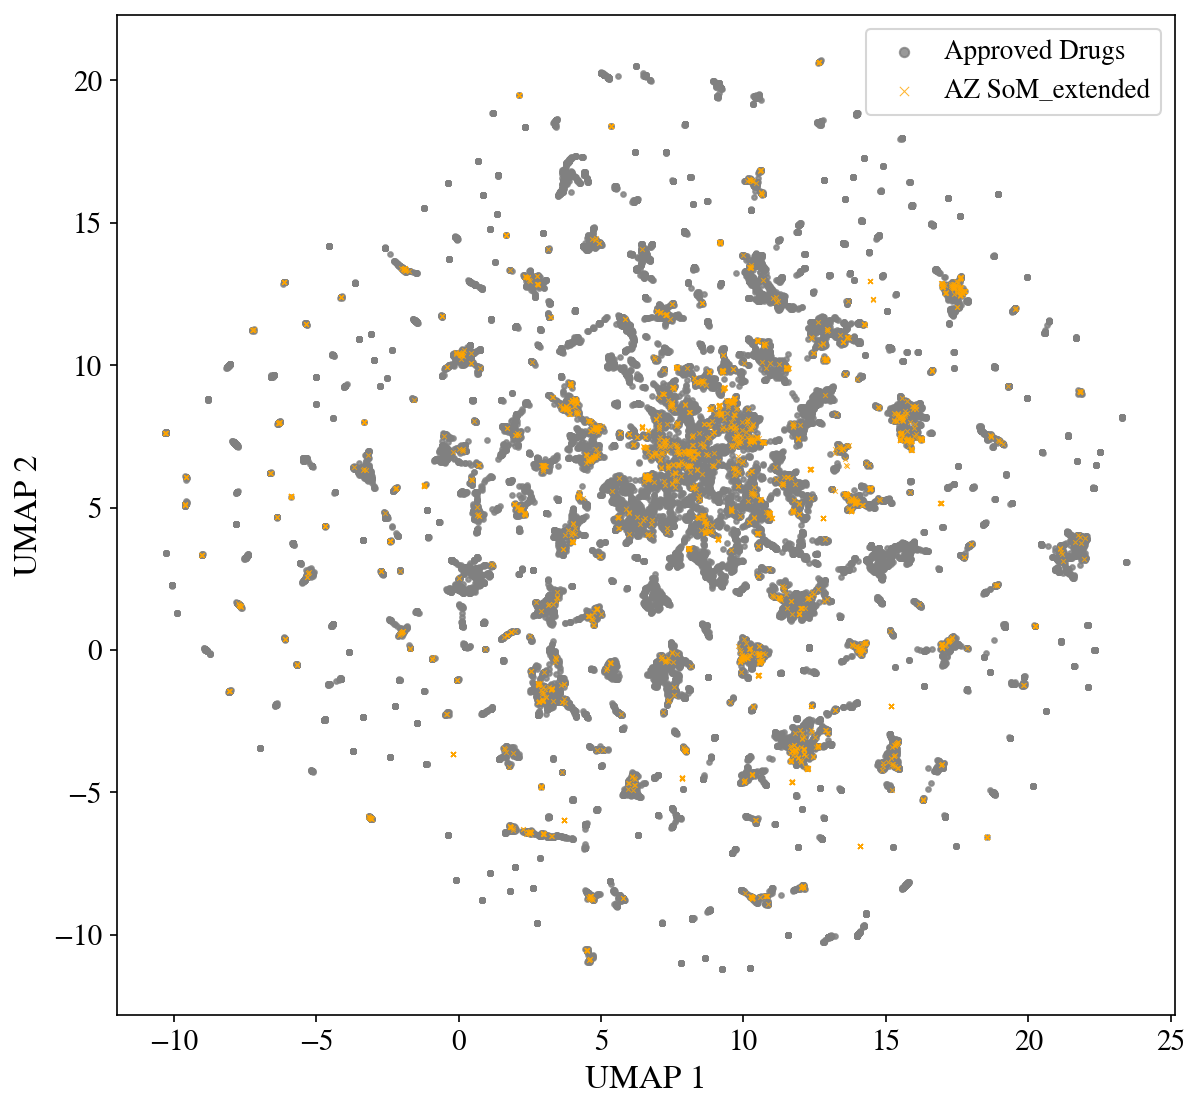

In [74]:
plt.rcParams['font.family'] = 'STIXGeneral'
fig = plt.figure(dpi=150)
axes = fig.add_subplot()
axes.set_xlabel('UMAP 1', fontsize=16)
axes.set_ylabel('UMAP 2', fontsize=16)
axes.set_aspect('equal', adjustable='box')

dbs = umapDF['db'].unique()
colors = ['gray', 'orange']  # Match colors from original code
markers = ['o', 'x']  # Circle for gray, x for orange
sizes = [5, 5]  # Larger size for gray dots
linewidths = [1, 0.5]  # Reduce line width for clearer x

for db, color, marker, size, linewidth in zip(dbs, colors, markers, sizes, linewidths):
    mask = umapDF['db'] == db
    axes.scatter(umapDF.loc[mask, 'UMAP 1'],
                umapDF.loc[mask, 'UMAP 2'],
                c=color, s=size, alpha=0.8,
                marker=marker, label=db,
                linewidth=linewidth)

axes.legend(dbs, fontsize=13, handletextpad=0.5, markerscale=2)
plt.tick_params(labelsize=14)

# Add padding
x_padding = (umapDF['UMAP 1'].max() - umapDF['UMAP 1'].min()) * 0.05
y_padding = (umapDF['UMAP 2'].max() - umapDF['UMAP 2'].min()) * 0.05
plt.xlim(umapDF['UMAP 1'].min() - x_padding, umapDF['UMAP 1'].max() + x_padding)
plt.ylim(umapDF['UMAP 2'].min() - y_padding, umapDF['UMAP 2'].max() + y_padding)

plt.tight_layout()
plt.show()


### AZ SoM_extended vs. SoM_exact

In [75]:
atoms_all_descriptors.loc[atoms_all_descriptors.set_index(['mol_id', 'atom_idx']).index.isin(atoms_explicit_descriptors.set_index(['mol_id', 'atom_idx']).index), 'db'] = 'AZ SoM_exact'

dataframe_atom_descriptor = pd.concat([drugs_atoms_descriptors,atoms_all_descriptors], ignore_index=True)

x = dataframe_atom_descriptor.loc[:, list(drugs_atoms_descriptors.columns[3:-1])].values

x = StandardScaler().fit_transform(x)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(x)
print(embedding.shape)
X_embeddedDF = pd.DataFrame(data=embedding, columns=['UMAP 1', 'UMAP 2'])

umapDF = pd.concat([X_embeddedDF, dataframe_atom_descriptor[['db']], dataframe_atom_descriptor[['mol_id']], dataframe_atom_descriptor[['atom_idx']]], axis=1)

/home/ychen/software/miniconda3/envs/az_som_py310/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/ychen/software/miniconda3/envs/az_som_py310/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


(50786, 2)


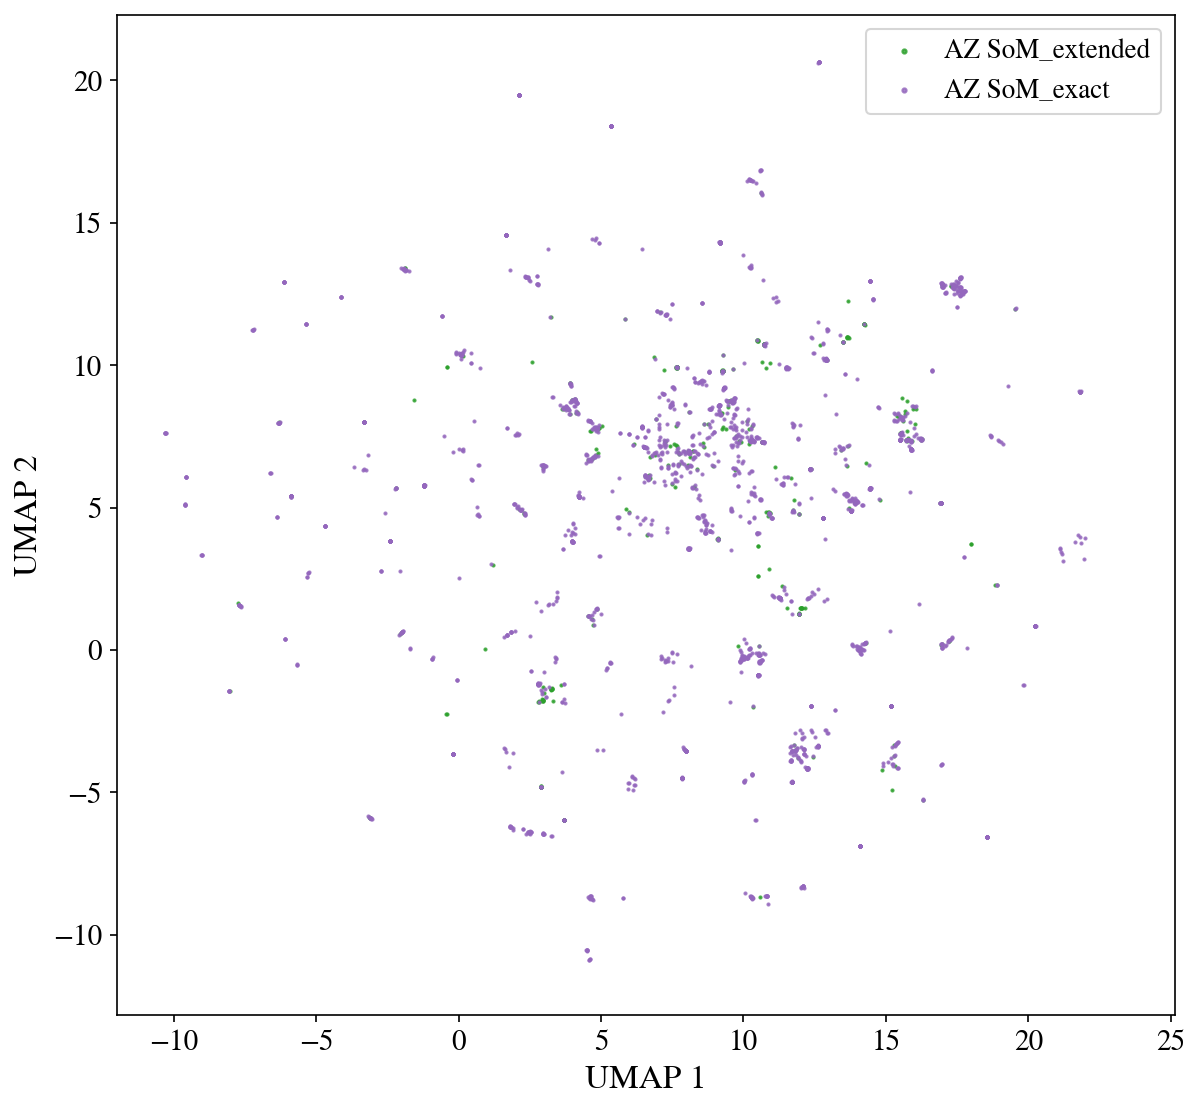

In [76]:
from src.utils.plot_utils import plot_umap

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
databases = ['AZ SoM_extended','AZ SoM_exact']
colors = default_colors[2:3]+default_colors[4:5]

plot_umap(umapDF,databases,colors)    


## similarity

In [77]:
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem

tqdm.pandas()

def get_rooted_fpBV_from_mol(mol,atom,radius=5, nBits=2048,useFeatures=False):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits, fromAtoms=[atom],useFeatures=useFeatures)

def get_rooted_fpBV_from_smi(smi,atom,radius=5, nBits=2048,useFeatures=False):
    mol = Chem.MolFromSmiles(smi)
    return get_rooted_fpBV_from_mol(mol,atom,radius, nBits,useFeatures)

In [78]:
atoms_all_descriptors['rooted5_2048_bv'] = atoms_all_descriptors.apply(lambda row: get_rooted_fpBV_from_smi(row['preprocessed_smi'], row['atom_idx']), axis=1)
atoms_explicit_descriptors['rooted5_2048_bv'] = atoms_explicit_descriptors.apply(lambda row: get_rooted_fpBV_from_smi(row['preprocessed_smi'], row['atom_idx']), axis=1)

In [79]:
from src.utils.mol_utils import preprocess, element_label, get_MW

drugs_df = PandasTools.LoadSDF('../data/drugbank_approveddrugs/approveddrugs_structures.sdf',removeHs=False)
drugs_df['preprocessed_mol'] = drugs_df['ROMol'].map(preprocess)
print(f'Dataframe was of lenth {len(drugs_df)}.')

drugs_df['element_label'] = drugs_df['preprocessed_mol'].apply(element_label)
drugs_df = drugs_df[drugs_df.element_label == 1]

print(f'Dataframe after element filter is now of lenth {len(drugs_df)}.')

[18:03:23] Explicit valence for atom # 28 N, 4, is greater than permitted
[18:03:23] ERROR: Could not sanitize molecule ending on line 327071
[18:03:23] ERROR: Explicit valence for atom # 28 N, 4, is greater than permitted


Dataframe was of lenth 2618.
Dataframe after element filter is now of lenth 2394.


In [80]:
print(f'Dataframe was of lenth {len(drugs_df)}.')

drugs_df['MW'] = drugs_df['preprocessed_mol'].map(get_MW)
drugs_df = drugs_df[drugs_df['MW'].between(100,1000)]
drugs_df.reset_index(drop=True, inplace=True)

print(f'Dataframe after molecular weight filter is now of lenth {len(drugs_df)}.')

Dataframe was of lenth 2394.
Dataframe after molecular weight filter is now of lenth 2252.


In [81]:
drugs_df.columns

Index(['DATABASE_ID', 'DATABASE_NAME', 'SMILES', 'INCHI_IDENTIFIER',
       'INCHI_KEY', 'FORMULA', 'MOLECULAR_WEIGHT', 'EXACT_MASS',
       'JCHEM_ACCEPTOR_COUNT', 'JCHEM_ATOM_COUNT',
       'JCHEM_AVERAGE_NEUTRAL_MICROSPECIES_CHARGE',
       'JCHEM_AVERAGE_POLARIZABILITY', 'JCHEM_BIOAVAILABILITY',
       'JCHEM_DONOR_COUNT', 'JCHEM_FORMAL_CHARGE', 'JCHEM_GHOSE_FILTER',
       'JCHEM_IUPAC', 'ALOGPS_LOGP', 'JCHEM_LOGP', 'ALOGPS_LOGS',
       'JCHEM_MDDR_LIKE_RULE', 'JCHEM_NEUTRAL_CHARGE', 'JCHEM_NUMBER_OF_RINGS',
       'JCHEM_PHYSIOLOGICAL_CHARGE', 'JCHEM_PKA', 'JCHEM_PKA_STRONGEST_ACIDIC',
       'JCHEM_PKA_STRONGEST_BASIC', 'JCHEM_POLAR_SURFACE_AREA',
       'JCHEM_REFRACTIVITY', 'JCHEM_ROTATABLE_BOND_COUNT',
       'JCHEM_RULE_OF_FIVE', 'ALOGPS_SOLUBILITY', 'JCHEM_TRADITIONAL_IUPAC',
       'JCHEM_VEBER_RULE', 'DRUGBANK_ID', 'SECONDARY_ACCESSION_NUMBERS',
       'DRUG_GROUPS', 'GENERIC_NAME', 'SYNONYMS', 'PRODUCTS',
       'INTERNATIONAL_BRANDS', 'ID', 'ROMol', 'SALTS', 'preproces

In [82]:
drugs_df['inchi_noStereo'] = drugs_df['preprocessed_mol'].map(get_inchi_noStereo_from_mol)
drugs_df = drugs_df.drop_duplicates('inchi_noStereo')
drugs_df['mol_id'] = drugs_df['DATABASE_ID']

In [83]:

drugs_atoms_descriptors_mol = pd.merge(drugs_df[['mol_id','ROMol']],drugs_atoms_descriptors,on=['mol_id'],how='inner')



drugs_atoms_descriptors_mol['rooted5_2048_bv'] = drugs_atoms_descriptors_mol.progress_apply(lambda row: get_rooted_fpBV_from_mol(row['ROMol'], int(row['atom_idx'])) if row['ROMol'] is not None else None, axis=1)

  0%|          | 0/48086 [00:00<?, ?it/s]

In [84]:
from rdkit import DataStructs
import numpy as np

def get_df_name(df):
    """Get the variable name of a dataframe"""
    try:
        name = [x for x in globals() if globals()[x] is df][0]
        return name
    except IndexError:
        return "unknown_df"

def np_to_bv(fv):
    """Convert numpy array to RDKit ExplicitBitVect
    
    Args:
        fv: Numpy array of bits
        
    Returns:
        RDKit ExplicitBitVect
    """
    bv = DataStructs.ExplicitBitVect(len(fv))
    on_bits = np.where(fv)[0]
    for i in on_bits:
        bv.SetBit(int(i))
    return bv

def atom_similarity_between(df1, df2, feature_list):
    """Calculate maximum Tanimoto similarity between atoms in two dataframes
    
    Args:
        df1: Reference dataframe containing fingerprints
        df2: Query dataframe to calculate similarities for
        feature_list: List of fingerprint column names
        
    Returns:
        Updates df2 with new column containing max similarities
    """
    # Get fingerprints from reference df
    if len(feature_list) == 1:
        ref_fps = list(df1[feature_list[0]])
    else:
        ref_fps = [np_to_bv(fp) for fp in df1[feature_list].values]

    def get_max_similarity(row):
        # Get fingerprint from query row
        if len(feature_list) == 1:
            query_fp = row[feature_list[0]]
        else:
            query_fp = np_to_bv(row[feature_list].values)
            
        # Calculate similarities and get maximum
        sims = DataStructs.BulkTanimotoSimilarity(query_fp, ref_fps)
        return max(sims)

    # Add similarity column to df2
    df2['closest_similarity_' + get_df_name(df1)] = df2.apply(get_max_similarity, axis=1)

In [85]:
atom_similarity_between(drugs_atoms_descriptors_mol,atoms_all_descriptors,['rooted5_2048_bv'])
atom_similarity_between(drugs_atoms_descriptors_mol,atoms_explicit_descriptors,['rooted5_2048_bv'])

In [86]:
az_public_atom_sim_list_drugs = list(atoms_all_descriptors.closest_similarity_drugs_atoms_descriptors_mol)
az_public_explicit_atom_sim_list_drugs = list(atoms_explicit_descriptors.closest_similarity_drugs_atoms_descriptors_mol)

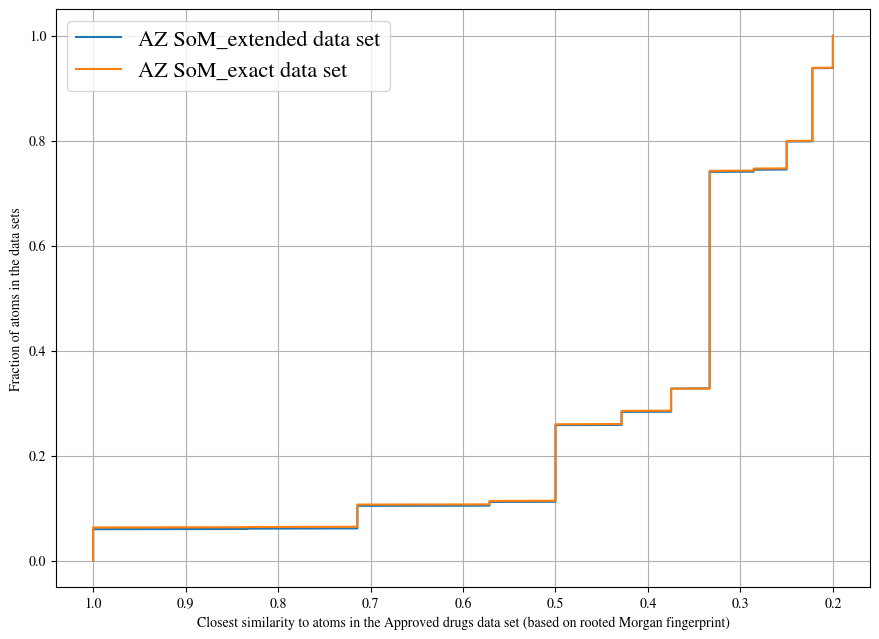

In [87]:
plt.rcParams['font.family'] = 'STIXGeneral'
# difficult to describe the beween 
plt.plot(sorted(az_public_atom_sim_list_drugs,reverse=True),np.array(list(range(len(az_public_atom_sim_list_drugs))))/len(az_public_atom_sim_list_drugs))
plt.plot(sorted(az_public_explicit_atom_sim_list_drugs,reverse=True),np.array(list(range(len(az_public_explicit_atom_sim_list_drugs))))/len(az_public_explicit_atom_sim_list_drugs))    
plt.legend(['AZ SoM_extended data set','AZ SoM_exact data set'], fontsize=16,loc='upper left')
# Invert x-axis
plt.gca().invert_xaxis()

plt.xlabel('Closest similarity to atoms in the Approved drugs data set (based on rooted Morgan fingerprint)')
plt.ylabel('Fraction of atoms in the data sets')
plt.grid(True)
plt.show()

### count identical fingerprints

In [88]:
# Function to convert RDKit ExplicitBitVect to a string representation
def convert_bitvect_to_string(bitvect):
    """
    Converts an RDKit ExplicitBitVect to a string representation.
    
    Parameters:
    -----------
    bitvect : rdkit.DataStructs.cDataStructs.ExplicitBitVect
        The bit vector to convert
        
    Returns:
    --------
    str
        A string representation of the bit vector
    """
    if bitvect is None:
        return ""
    
    # Convert to a binary string (0s and 1s)
    bits = []
    for i in range(bitvect.GetNumBits()):
        if bitvect.GetBit(i):
            bits.append('1')
        else:
            bits.append('0')
    
    return ''.join(bits)

In [89]:
# Convert rooted5_2048_bv to string for easier comparison and deduplication
for df in [atoms_all_descriptors, atoms_explicit_descriptors, drugs_atoms_descriptors_mol]:
    df['rooted5_2048_bv_str'] = df['rooted5_2048_bv'].apply(convert_bitvect_to_string)

In [90]:
print(atoms_all_descriptors.shape)
print(atoms_all_descriptors.drop_duplicates(subset=['rooted5_2048_bv_str']).shape)
print(atoms_explicit_descriptors.shape)
print(atoms_explicit_descriptors.drop_duplicates(subset=['rooted5_2048_bv_str']).shape)
### UMAP with rooted fingerprint

(2700, 1597)
(1847, 1597)
(2321, 1597)
(1607, 1597)


In [91]:
print(drugs_atoms_descriptors_mol.shape)
print(drugs_atoms_descriptors_mol.drop_duplicates(subset=['rooted5_2048_bv_str']).shape)


(48086, 1595)
(36586, 1595)


In [92]:
# Generate rooted fingerprints for each radius (1-5) for all datasets
for radius in range(1,6):
    # Generate fingerprints for atoms_all
    atoms_all_descriptors[f'rooted{radius}_2048_bv'] = atoms_all_descriptors.apply(
        lambda row: get_rooted_fpBV_from_smi(row['preprocessed_smi'], row['atom_idx'], radius=radius), 
        axis=1
    )
    atoms_all_descriptors[f'rooted{radius}_2048_bv_str'] = atoms_all_descriptors.apply(
        lambda row: convert_bitvect_to_string(row[f'rooted{radius}_2048_bv']),
        axis=1
    )
    
    atoms_explicit_descriptors[f'rooted{radius}_2048_bv'] = atoms_explicit_descriptors.apply(
        lambda row: get_rooted_fpBV_from_smi(row['preprocessed_smi'], row['atom_idx'], radius=radius),
        axis=1
    )
    atoms_explicit_descriptors[f'rooted{radius}_2048_bv_str'] = atoms_explicit_descriptors.apply(
        lambda row: convert_bitvect_to_string(row[f'rooted{radius}_2048_bv']),
        axis=1
    )
    
    # Generate fingerprints for drugs
    drugs_atoms_descriptors_mol[f'rooted{radius}_2048_bv'] = drugs_atoms_descriptors_mol.apply(
        lambda row: get_rooted_fpBV_from_mol(row['ROMol'], row['atom_idx'], radius=radius),
        axis=1
    )
    drugs_atoms_descriptors_mol[f'rooted{radius}_2048_bv_str'] = drugs_atoms_descriptors_mol.apply(
        lambda row: convert_bitvect_to_string(row[f'rooted{radius}_2048_bv']),
        axis=1
    )   
    

In [93]:
# Convert all fingerprint bitvectors to strings for each dataset and radius
for radius in range(1, 6):
    # Convert for AZ public atoms
    atoms_all_descriptors[f'rooted{radius}_2048_str'] = atoms_all_descriptors[f'rooted{radius}_2048_bv'].apply(convert_bitvect_to_string)
    
    # Convert for drugs atoms
    drugs_atoms_descriptors_mol[f'rooted{radius}_2048_str'] = drugs_atoms_descriptors_mol[f'rooted{radius}_2048_bv'].apply(convert_bitvect_to_string)
    

print("Converted all fingerprint bit vectors to string representations")

Converted all fingerprint bit vectors to string representations


In [94]:
# Calculate number of unique fingerprints in each dataset for each radius
print("=== Number of Unique Fingerprints ===")
for radius in range(1, 6):
    # Count unique fingerprints in AZ public atoms
    unique_az = atoms_all_descriptors[f'rooted{radius}_2048_str'].nunique()
    total_az = len(atoms_all_descriptors)
    
    # Count unique fingerprints in drugs atoms
    unique_drugs = drugs_atoms_descriptors_mol[f'rooted{radius}_2048_str'].nunique()
    total_drugs = len(drugs_atoms_descriptors_mol)
    
    
    print(f"\nRadius {radius}:")
    print(f"AZ public atoms: {unique_az} unique fingerprints out of {total_az} total ({unique_az/total_az:.2%})")
    print(f"Drugs atoms: {unique_drugs} unique fingerprints out of {total_drugs} total ({unique_drugs/total_drugs:.2%})")


# Calculate overlap between datasets
print("\n=== Overlap Between Datasets ===")
for radius in range(1, 6):
    # Get unique fingerprints from each dataset
    unique_az_fps = set(atoms_all_descriptors[f'rooted{radius}_2048_str'])
    unique_drugs_fps = set(drugs_atoms_descriptors_mol[f'rooted{radius}_2048_str'])
    
    # Calculate overlaps
    az_drugs_overlap = len(unique_az_fps.intersection(unique_drugs_fps))
    
    # Calculate percentages
    az_drugs_pct_of_az = az_drugs_overlap / len(unique_az_fps) if len(unique_az_fps) > 0 else 0
    az_drugs_pct_of_drugs = az_drugs_overlap / len(unique_drugs_fps) if len(unique_drugs_fps) > 0 else 0
    
    print(f"\nRadius {radius}:")
    print(f"AZ-Drugs overlap: {az_drugs_overlap} fingerprints")
    print(f"  - {az_drugs_pct_of_az:.2%} of unique AZ fingerprints")
    print(f"  - {az_drugs_pct_of_drugs:.2%} of unique Drugs fingerprints")

=== Number of Unique Fingerprints ===

Radius 1:
AZ public atoms: 411 unique fingerprints out of 2700 total (15.22%)
Drugs atoms: 2307 unique fingerprints out of 48086 total (4.80%)

Radius 2:
AZ public atoms: 1127 unique fingerprints out of 2700 total (41.74%)
Drugs atoms: 13950 unique fingerprints out of 48086 total (29.01%)

Radius 3:
AZ public atoms: 1512 unique fingerprints out of 2700 total (56.00%)
Drugs atoms: 25396 unique fingerprints out of 48086 total (52.81%)

Radius 4:
AZ public atoms: 1697 unique fingerprints out of 2700 total (62.85%)
Drugs atoms: 31895 unique fingerprints out of 48086 total (66.33%)

Radius 5:
AZ public atoms: 1847 unique fingerprints out of 2700 total (68.41%)
Drugs atoms: 36586 unique fingerprints out of 48086 total (76.08%)

=== Overlap Between Datasets ===

Radius 1:
AZ-Drugs overlap: 377 fingerprints
  - 91.73% of unique AZ fingerprints
  - 16.34% of unique Drugs fingerprints

Radius 2:
AZ-Drugs overlap: 600 fingerprints
  - 53.24% of unique AZ fin

In [95]:
# Create a summary table of the dataset statistics and overlaps
import pandas as pd
from IPython.display import display, HTML

# Initialize data for the table
data = []
for radius in range(1, 6):
    # Get unique fingerprints from each dataset
    unique_az_fps = set(atoms_all_descriptors[f'rooted{radius}_2048_str'])
    unique_drugs_fps = set(drugs_atoms_descriptors_mol[f'rooted{radius}_2048_str'])
    
    # Calculate total counts
    total_az = len(atoms_all)
    total_drugs = len(drugs_atoms_descriptors_mol)
    
    # Calculate overlaps
    az_drugs_overlap = len(unique_az_fps.intersection(unique_drugs_fps))
    
    # Add row to data
    data.append({
        'Bond length': radius,
        'AZ SoM_extended unique atom environments': len(unique_az_fps),
        'AZ SoM_extended total atoms': total_az,
        'AZ SoM_extended uniqueness': total_az/len(unique_az_fps),
        'Drugs Unique atom environments': len(unique_drugs_fps),
        'Drugs Total atoms': total_drugs,
        'Drugs uniqueness': total_drugs/len(unique_drugs_fps),
        'AZ SoM_extended\u2229Drugs': az_drugs_overlap,
        'AZ SoM_extended\u2229Drugs % of AZ SoM_extended': f"{az_drugs_overlap/len(unique_az_fps):.2%}" if len(unique_az_fps) > 0 else "0.00%",
        'AZ SoM_extended\u2229Drugs % of Drugs': f"{az_drugs_overlap/len(unique_drugs_fps):.2%}" if len(unique_drugs_fps) > 0 else "0.00%"
    })

# Create DataFrame
summary_df = pd.DataFrame(data)

# Display the table with better formatting
display(HTML(summary_df.to_html(index=False)))

Bond length,AZ SoM_extended unique atom environments,AZ SoM_extended total atoms,AZ SoM_extended uniqueness,Drugs Unique atom environments,Drugs Total atoms,Drugs uniqueness,AZ SoM_extended∩Drugs,AZ SoM_extended∩Drugs % of AZ SoM_extended,AZ SoM_extended∩Drugs % of Drugs
1,411,2700,6.569343,2307,48086,20.843520,377,91.73%,16.34%
2,1127,2700,2.395741,13950,48086,3.447025,600,53.24%,4.30%
3,1512,2700,1.785714,25396,48086,1.893448,328,21.69%,1.29%
4,1697,2700,1.591043,31895,48086,1.507634,181,10.67%,0.57%
5,1847,2700,1.461830,36586,48086,1.314328,122,6.61%,0.33%


In [96]:
# create a more readable version with better column names for presentation
readable_summary = summary_df.copy()
readable_summary.columns = [col.replace('\u2229', ' ∩ ') for col in readable_summary.columns]
readable_csv = "../output/az_extended_drugs_overlap_atom_environment_summary_readable_120shared.csv"
readable_summary.to_csv(readable_csv, index=False)
print(f"Readable summary exported to {readable_csv}")



Readable summary exported to ../output/az_extended_drugs_overlap_atom_environment_summary_readable_120shared.csv


#### calcualte for AZ SoM_exact

In [97]:
for radius in range(1, 6):
    # Convert for AZ public atoms
    atoms_explicit_descriptors[f'rooted{radius}_2048_str'] = atoms_explicit_descriptors[f'rooted{radius}_2048_bv'].apply(convert_bitvect_to_string)

In [98]:
# Calculate number of unique fingerprints in each dataset for each radius
print("=== Number of Unique Fingerprints ===")
for radius in range(1, 6):
    # Count unique fingerprints in AZ public atoms
    unique_az_exact = atoms_explicit_descriptors[f'rooted{radius}_2048_str'].nunique()
    total_az_exact = len(atoms_explicit_descriptors)
    
    # Count unique fingerprints in drugs atoms
    unique_drugs = drugs_atoms_descriptors_mol[f'rooted{radius}_2048_str'].nunique()
    total_drugs = len(drugs_atoms_descriptors_mol)
    
    print(f"\nRadius {radius}:")
    print(f"AZ public exact atoms: {unique_az_exact} unique fingerprints out of {total_az_exact} total ({unique_az_exact/total_az_exact:.2%})")
    print(f"Drugs atoms: {unique_drugs} unique fingerprints out of {total_drugs} total ({unique_drugs/total_drugs:.2%})")

# Calculate overlap between datasets
print("\n=== Overlap Between Datasets ===")
for radius in range(1, 6):
    # Get unique fingerprints from each dataset
    unique_az_fps = set(atoms_explicit_descriptors[f'rooted{radius}_2048_str'])
    unique_drugs_fps = set(drugs_atoms_descriptors_mol[f'rooted{radius}_2048_str'])
    
    # Calculate overlaps
    az_drugs_overlap = len(unique_az_fps.intersection(unique_drugs_fps))
    
    # Calculate percentages
    az_drugs_pct_of_az_exact = az_drugs_overlap / unique_az_exact if unique_az_exact > 0 else 0
    az_drugs_pct_of_drugs = az_drugs_overlap / len(unique_drugs_fps) if unique_drugs_fps else 0

    print(f"AZ-Drugs overlap: {az_drugs_overlap} fingerprints")
    print(f"  - {az_drugs_pct_of_az_exact:.2%} of unique AZ fingerprints")
    print(f"  - {az_drugs_pct_of_drugs:.2%} of unique Drugs fingerprints")


=== Number of Unique Fingerprints ===

Radius 1:
AZ public exact atoms: 387 unique fingerprints out of 2321 total (16.67%)
Drugs atoms: 2307 unique fingerprints out of 48086 total (4.80%)

Radius 2:
AZ public exact atoms: 1009 unique fingerprints out of 2321 total (43.47%)
Drugs atoms: 13950 unique fingerprints out of 48086 total (29.01%)

Radius 3:
AZ public exact atoms: 1323 unique fingerprints out of 2321 total (57.00%)
Drugs atoms: 25396 unique fingerprints out of 48086 total (52.81%)

Radius 4:
AZ public exact atoms: 1481 unique fingerprints out of 2321 total (63.81%)
Drugs atoms: 31895 unique fingerprints out of 48086 total (66.33%)

Radius 5:
AZ public exact atoms: 1607 unique fingerprints out of 2321 total (69.24%)
Drugs atoms: 36586 unique fingerprints out of 48086 total (76.08%)

=== Overlap Between Datasets ===
AZ-Drugs overlap: 353 fingerprints
  - 21.97% of unique AZ fingerprints
  - 15.30% of unique Drugs fingerprints
AZ-Drugs overlap: 545 fingerprints
  - 33.91% of uniqu

In [99]:
# Create a summary table of the dataset statistics and overlaps
import pandas as pd
from IPython.display import display, HTML

# Initialize data for the table
data = []

for radius in range(1, 6):
    # Get unique fingerprints from each dataset
    unique_az_fps = set(atoms_explicit_descriptors[f'rooted{radius}_2048_str'])
    unique_drugs_fps = set(drugs_atoms_descriptors_mol[f'rooted{radius}_2048_str'])
    
    # Calculate total counts
    total_az = len(atoms_explicit_descriptors)
    total_drugs = len(drugs_atoms_descriptors_mol)
    
    # Calculate overlaps
    az_drugs_overlap = len(unique_az_fps.intersection(unique_drugs_fps))
    
    # Add row to data
    data.append({
        'Bond length': radius,
        'AZ SoM_exact unique atom environments': len(unique_az_fps),
        'AZ SoM_exact total atoms': total_az,
        'AZ SoM_exact uniqueness': total_az/len(unique_az_fps),
        'Drugs unique atom environments': len(unique_drugs_fps),
        'Drugs total atoms': total_drugs,
        'Drugs uniqueness': total_drugs/len(unique_drugs_fps),
        'AZ SoM_exact∩Drugs': az_drugs_overlap,
        'AZ SoM_exact∩Drugs % of AZ SoM_exact': f"{az_drugs_overlap/len(unique_az_fps):.2%}" if len(unique_az_fps) > 0 else "0.00%",
        'AZ SoM_exact∩Drugs % of Drugs': f"{az_drugs_overlap/len(unique_drugs_fps):.2%}" if len(unique_drugs_fps) > 0 else "0.00%",
    })

# Create DataFrame
summary_df = pd.DataFrame(data)

# Display the table with better formatting
display(HTML(summary_df.to_html(index=False)))

Bond length,AZ SoM_exact unique atom environments,AZ SoM_exact total atoms,AZ SoM_exact uniqueness,Drugs unique atom environments,Drugs total atoms,Drugs uniqueness,AZ SoM_exact∩Drugs,AZ SoM_exact∩Drugs % of AZ SoM_exact,AZ SoM_exact∩Drugs % of Drugs
1,387,2321,5.997416,2307,48086,20.843520,353,91.21%,15.30%
2,1009,2321,2.300297,13950,48086,3.447025,545,54.01%,3.91%
3,1323,2321,1.754346,25396,48086,1.893448,288,21.77%,1.13%
4,1481,2321,1.567184,31895,48086,1.507634,160,10.80%,0.50%
5,1607,2321,1.444306,36586,48086,1.314328,108,6.72%,0.30%


In [100]:
# Also create a more readable version with better column names for presentation
readable_summary = summary_df.copy()
readable_summary.columns = [col.replace('\u2229', ' ∩ ') for col in readable_summary.columns]
readable_csv = "../output/az_exact_drugs_overlap_atom_environment_summary_readable_120shared.csv"
readable_summary.to_csv(readable_csv, index=False)
print(f"Readable summary exported to {readable_csv}")

Readable summary exported to ../output/az_exact_drugs_overlap_atom_environment_summary_readable_120shared.csv


# End